In [1]:
import os
from functools import reduce

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd

import patchworklib as pw
import pingouin as pg
import seaborn as sns
import xarray as xr
from data_utils import get_gfp_peaks
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.metrics import accuracy_score

plt.style.use("papers")
plt.rcParams.update(
    {
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "savefig.facecolor": "white",
    }
)
pw.overwrite_axisgrid()

COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]

FOLDER = "../../results/aggregated/"

DATA_TYPE = "real_data"
EOC = "EC"

<Figure size 72x72 with 0 Axes>

In [2]:
xr.open_dataarray(os.path.join(FOLDER, "segmentations.nc"))

<xarray.DataArray (data_type: 2, surrogate_type: 5, decomposition_type: 6, subject_id: 203, time: 62501)>
[761262180 values with dtype=float64]
Coordinates:
  * subject_id          (subject_id) object 'sub-010002' ... 'sub-010321'
  * time                (time) float64 0.0 0.004 0.008 ... 250.0 250.0 250.0
    no_states           int64 ...
  * decomposition_type  (decomposition_type) object 'AAHC' 'ICA' ... 'kmeans'
  * surrogate_type      (surrogate_type) object 'AAFT' 'FT' ... 'shuffle'
  * data_type           (data_type) object 'EC' 'EO'

In [3]:
segmentations = (
    xr.open_dataarray(os.path.join(FOLDER, "segmentations.nc"))
    .squeeze()
    .sel({"data_type": EOC, "surrogate_type": DATA_TYPE})
    .rename({"decomposition_type": "algorithm"})
)
segm_df = (
    segmentations.to_series()
    .reset_index()
    .replace({"hmm": "HMM", "kmeans": "mod. K-Means"})
    .rename(columns={0: "segmentation"})
)

In [4]:
def acc(x, y):
    nans = x.isna() | y.isna()
    x = x[~nans]
    y = y[~nans]
    return accuracy_score(x, y)


segm_grp = segm_df.pivot(
    index=["subject_id", "time"], columns="algorithm", values="segmentation"
)
accs = []
for subj, df_ in segm_grp.groupby("subject_id"):
    acc_ = df_.apply(lambda x: df_.apply(lambda y: acc(x, y)))
    acc_["subject_id"] = subj
    acc_ = acc_.reset_index().set_index(["subject_id", "algorithm"])
    accs.append(acc_)
segm_acc = pd.concat(accs, axis=0).unstack()
segm_acc

algorithm  AAHC                                                       \
algorithm  AAHC       HMM       ICA       PCA     TAAHC mod. K-Means   
subject_id                                                             
sub-010002  1.0  0.254735  0.454191  0.413772  0.615628     0.589288   
sub-010003  1.0  0.269975  0.265835  0.097518  0.475290     0.619768   
sub-010004  1.0  0.269535  0.499770  0.394492  0.890762     0.617908   
sub-010005  1.0  0.255275  0.281794  0.230695  0.173077     0.482750   
sub-010006  1.0  0.232675  0.447731  0.423372  0.691626     0.396592   
...         ...       ...       ...       ...       ...          ...   
sub-010316  1.0  0.254335  0.347833  0.246495  0.697946     0.503210   
sub-010317  1.0  0.280274  0.372933  0.248655  0.667987     0.776144   
sub-010318  1.0  0.243775  0.234395  0.370333  0.774665     0.722126   
sub-010319  1.0  0.278294  0.421812  0.438691  0.270275     0.758085   
sub-010321  1.0  0.234055  0.239295  0.264595  0.272215     0.328933   

algorithm        HMM                           ...     TAAHC                  \
algorithm       AAHC  HMM       ICA       PCA  ...       ICA       PCA TAAHC   
subject_id                                     ...                             
sub-010002  0.254735  1.0  0.260775  0.357513  ...  0.364693  0.409052   1.0   
sub-010003  0.269975  1.0  0.262495  0.273655  ...  0.234675  0.323894   1.0   
sub-010004  0.269535  1.0  0.279294  0.238975  ...  0.471251  0.411852   1.0   
sub-010005  0.255275  1.0  0.253835  0.348813  ...  0.261315  0.311794   1.0   
sub-010006  0.232675  1.0  0.298974  0.231555  ...  0.452591  0.312714   1.0   
...              ...  ...       ...       ...  ...       ...       ...   ...   
sub-010316  0.254335  1.0  0.280694  0.231635  ...  0.365453  0.274855   1.0   
sub-010317  0.280274  1.0  0.254435  0.258035  ...  0.416092  0.201796   1.0   
sub-010318  0.243775  1.0  0.223216  0.472051  ...  0.188556  0.458091   1.0   
sub-010319  0.278294  1.0  0.260675  0.263315  ...  0.215996  0.168037   1.0   
sub-010321  0.234055  1.0  0.181716  0.076598  ...  0.313774  0.317554   1.0   

algorithm               mod. K-Means                                          \
algorithm  mod. K-Means         AAHC       HMM       ICA       PCA     TAAHC   
subject_id                                                                     
sub-010002     0.631347     0.589288  0.275674  0.339713  0.319354  0.631347   
sub-010003     0.436491     0.619768  0.242555  0.322154  0.086318  0.436491   
sub-010004     0.670107     0.617908  0.286094  0.373173  0.405852  0.670107   
sub-010005     0.411132     0.482750  0.237515  0.496990  0.153177  0.411132   
sub-010006     0.454351     0.396592  0.338693  0.531489  0.145177  0.454351   
...                 ...          ...       ...       ...       ...       ...   
sub-010316     0.443451     0.503210  0.266475  0.231195  0.266855  0.443451   
sub-010317     0.848383     0.776144  0.280374  0.378892  0.215796  0.848383   
sub-010318     0.762605     0.722126  0.272915  0.194696  0.364933  0.762605   
sub-010319     0.231275     0.758085  0.256695  0.389072  0.387992  0.231275   
sub-010321     0.559669     0.328933  0.206176  0.371053  0.374153  0.559669   

algorithm                
algorithm  mod. K-Means  
subject_id               
sub-010002          1.0  
sub-010003          1.0  
sub-010004          1.0  
sub-010005          1.0  
sub-010006          1.0  
...                 ...  
sub-010316          1.0  
sub-010317          1.0  
sub-010318          1.0  
sub-010319          1.0  
sub-010321          1.0  

[203 rows x 36 columns]

In [5]:
# segm_corrs = (
#     segm_df.pivot(
#         index=["subject_id", "time"], columns="algorithm", values="segmentation"
#     )
#     .groupby("subject_id")
#     .corr("spearman")
#     .unstack()
# )

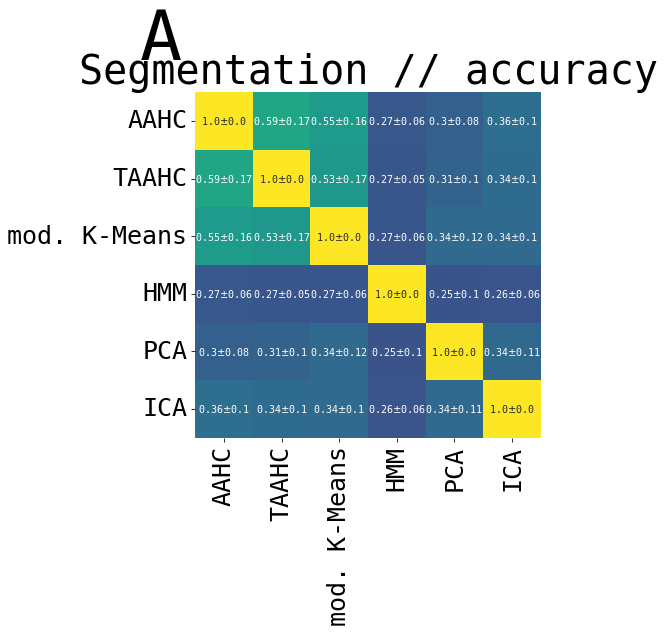

In [6]:
segm_mean = segm_acc.mean().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_mean.index.name = ""
segm_mean.columns.name = ""

segm_std = segm_acc.std().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_std.index.name = ""
segm_std.columns.name = ""

g1 = pw.Brick("ax0", figsize=(6, 6))
sns.heatmap(
    segm_mean,
    square=True,
    vmin=0,
    vmax=1,
    cmap="viridis",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
    ax=g1,
)
g1.set_title("Segmentation // accuracy")
g1.text(
    -0.1,
    1.15,
    "A",
    ha="center",
    va="center",
    transform=g1.transAxes,
    fontsize=70,
)
g1.savefig(quick=True)

In [7]:
stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats

,subject_id,latent map,var_GFP,var_total,template_corr,coverage,occurrence,lifespan,transition->A,transition->B,...,stationarity L=500 p-val,stationarity L=1000 t,stationarity L=1000 p-val,stationarity L=2500 t,stationarity L=2500 p-val,stationarity L=5000 t,stationarity L=5000 p-val,Hurst exp.,Hurst intercept,data_type
0,sub-010002_EC,A,0.432522,0.408758,0.224551,0.306875,17.259724,17.779838,0.775026,0.077372,...,9.990723e-01,669.527832,9.519529e-01,249.534664,9.507434e-01,126.085424,0.628695,0.589165,1.391838,EC
1,sub-010002_EC,B,0.432522,0.408758,0.439228,0.233308,15.403754,15.146196,0.101838,0.735907,...,9.990723e-01,669.527832,9.519529e-01,249.534664,9.507434e-01,126.085424,0.628695,0.589165,1.391838,EC
2,sub-010002_EC,C,0.432522,0.408758,0.932776,0.212541,14.435769,14.726164,0.098163,0.085140,...,9.990723e-01,669.527832,9.519529e-01,249.534664,9.507434e-01,126.085424,0.628695,0.589165,1.391838,EC
3,sub-010002_EC,D,0.432522,0.408758,0.621642,0.247276,15.735748,15.707168,0.098745,0.079979,...,9.990723e-01,669.527832,9.519529e-01,249.534664,9.507434e-01,126.085424,0.628695,0.589165,1.391838,EC
4,sub-010003_EC,A,0.369504,0.366026,0.030020,0.267708,11.283819,23.724920,0.831401,0.058750,...,4.116232e-01,707.873687,7.324179e-01,281.711831,5.933245e-01,133.540346,0.446132,0.523192,2.366292,EC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48587,sub-010321_EO,D,0.752405,0.696908,0.950558,0.274055,15.544689,17.634492,0.064292,0.083120,...,1.443494e-24,962.533144,1.429370e-20,349.861393,3.657611e-07,156.679748,0.001545,0.567801,1.609696,EO
48588,sub-010318_EO,A,0.682292,0.630221,0.912150,0.233735,13.824724,16.907052,0.763412,0.074613,...,6.723853e-03,660.535717,2.002536e-02,238.368706,3.052018e-01,128.497492,0.086948,0.550834,1.746949,EO
48589,sub-010318_EO,B,0.682292,0.630221,0.946033,0.233995,13.434731,17.422189,0.072393,0.770342,...,6.723853e-03,660.535717,2.002536e-02,238.368706,3.052018e-01,128.497492,0.086948,0.550834,1.746949,EO
48590,sub-010318_EO,C,0.682292,0.630221,0.931717,0.278554,14.634707,19.032456,0.075680,0.070367,...,6.723853e-03,660.535717,2.002536e-02,238.368706,3.052018e-01,128.497492,0.086948,0.550834,1.746949,EO


In [8]:
stats = pd.read_csv(os.path.join(FOLDER, "stats.csv"))
stats = stats[(stats["surrogate_type"] == DATA_TYPE) & (stats["data_type"] == EOC)]
stats = stats.rename(columns={"decomposition_type": "algorithm"}).replace(
    {"hmm": "HMM", "kmeans": "mod. K-Means"}
)
stats = stats.sort_values(by="algorithm")

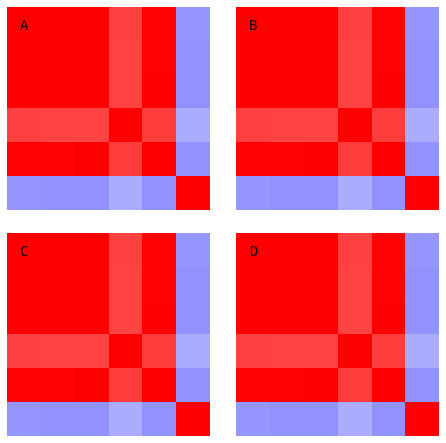

In [9]:
for var in ["coverage", "lifespan", "occurrence", "var GFP"]:

    corrs = (
        stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
        .set_index("algorithm")
        .loc[COLUMNS_ORDER]
        .reset_index()
        .set_index(["algorithm", "subject_id", "latent map"])[var]
        .reset_index()
        .pivot(columns="algorithm", index=["latent map", "subject_id"], values=var)
        .groupby(level=0)
        .corr()
    )

    data = corrs.reset_index().melt(id_vars=["latent map", "algorithm"])
    data = (
        corrs.reset_index()
        .melt(id_vars=["latent map", "algorithm"], var_name="alg1")
        .rename(columns={"algorithm": "alg2"})
    )
    # data.columns = ["latent map", "algo1", "algo2", "value"]
    # data[data["latent map"] == "A"]#.pivot(index="algo1", columns="algo2", values="value")


    def draw_heatmap(*args, **kwargs):
        data = kwargs.pop("data")
        d = data.pivot(index=args[1], columns=args[0], values=args[2]).loc[
            COLUMNS_ORDER, COLUMNS_ORDER
        ]
        sns.heatmap(d, **kwargs)


    fg = sns.FacetGrid(data, col="latent map", col_wrap=2)
    fg.map_dataframe(
        draw_heatmap,
        "alg1",
        "alg2",
        "value",
        cbar=False,
        square=True,
        vmin=-1,
        vmax=1,
        cmap="bwr",
    )
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    tits = data.groupby("latent map").groups.keys()
    for ax, tit in zip(fg.axes, tits):
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("")
        ax.text(0.5, 0.55, tit, size=14, ha="center", va="center")
    g_temp = pw.load_seaborngrid(fg)
    g_temp.savefig(f"LEMON_{DATA_TYPE}_{EOC}_subjectwise_corrs_{var}.pdf", transparent=True, bbox_inches="tight")
    # plt.savefig(f"LEMON_{DATA_TYPE}_{EOC}_subjectwise_corrs_{var}.pdf", transparent=True, bbox_inches="tight")

In [10]:
# _, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 8))
# axs = axs.flatten()
# for i, (map_, corr) in enumerate(corrs.groupby(level=0)):
#     sns.heatmap(corr.droplevel(0).loc[COLUMNS_ORDER, COLUMNS_ORDER], vmin=-1, vmax=1, cmap="bwr", ax=axs[i], cbar=False, square=True)
#     axs[i].text(0.5, 0.5, map_, ha="center", va="center", size=20)

# for ax in axs:
#     ax.set_xlabel("")
#     ax.set_ylabel("")
#     ax.set_xticks([])
#     ax.set_yticks([])

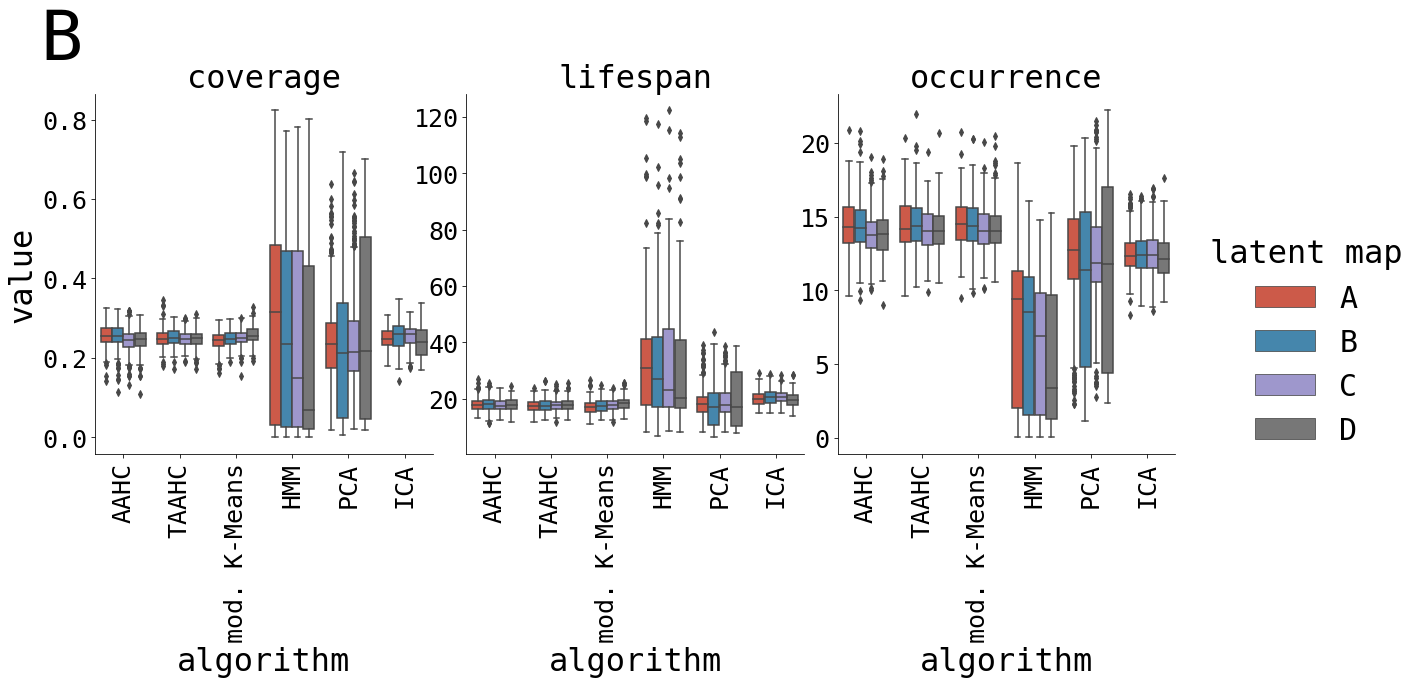

In [11]:
stats = (
    stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
stats_melt["value"] = stats_melt["value"].where(stats_melt["value"] < 200., np.nan)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    hue_order=["A", "B", "C", "D"],
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0][0].text(
    -0.1,
    1.15,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

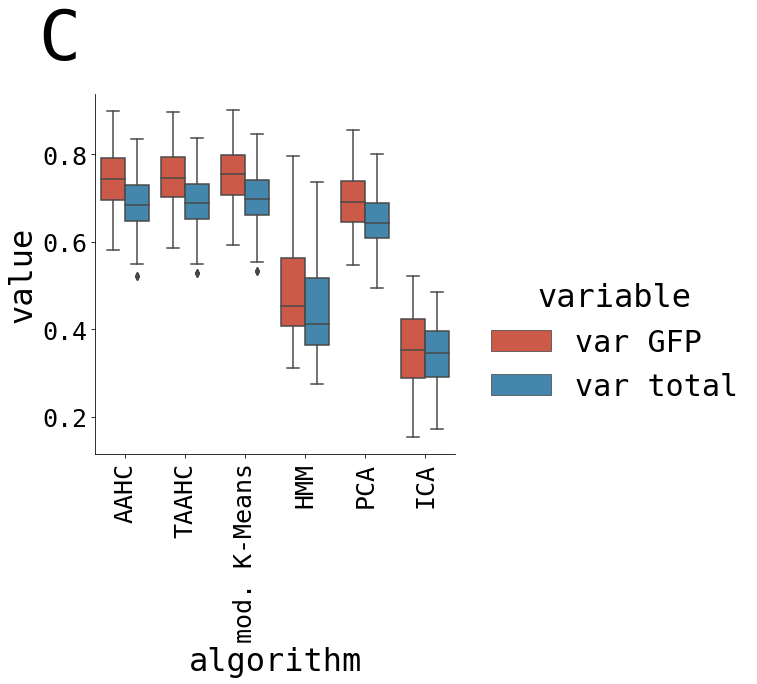

In [12]:
g = sns.catplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
g.axes[0][0].text(
    -0.1,
    1.15,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

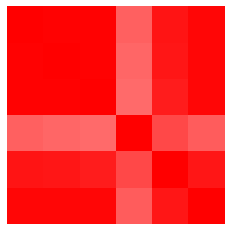

In [13]:
for var in ["mixing time", "entropy", "AIF 1st peak [ms]", "entropy rate"]:

    corrs = (
        stats.rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
        .set_index("algorithm")
        .loc[COLUMNS_ORDER]
        .reset_index().drop_duplicates(subset=["subject_id", "algorithm", var])
        .set_index(["algorithm", "subject_id"])[var].to_frame().reset_index()
        .pivot(columns="algorithm", index=["subject_id"], values=var)
        .corr()
    )
    data = (
        corrs.reset_index()
        .melt(id_vars=["algorithm"], var_name="alg1")
        .rename(columns={"algorithm": "alg2"})
    )
    data

    sns.heatmap(corrs.loc[COLUMNS_ORDER, COLUMNS_ORDER], vmin=-1, vmax=1, cmap="bwr", cbar=False, square=True)
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks([])
    plt.yticks([])
    plt.savefig(f"LEMON_{DATA_TYPE}_{EOC}_subjectwise_corrs_{var}.pdf", transparent=True, bbox_inches="tight")


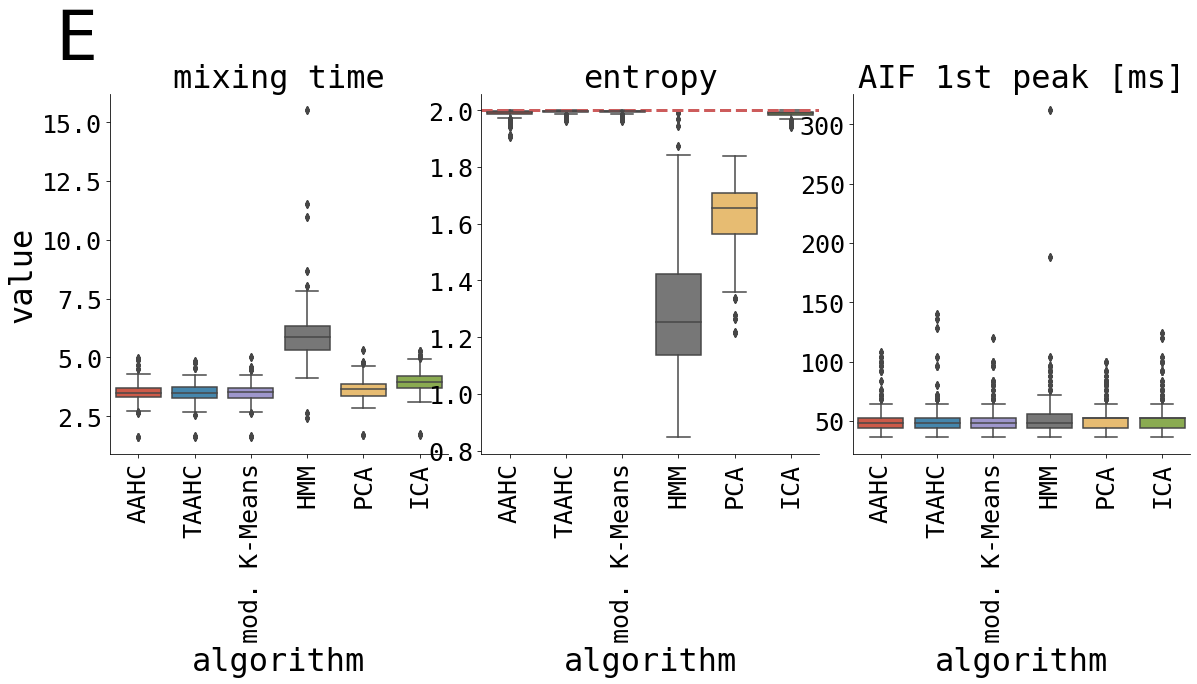

In [14]:
dynstats_melt = (
    stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak [ms]"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    stats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "E",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

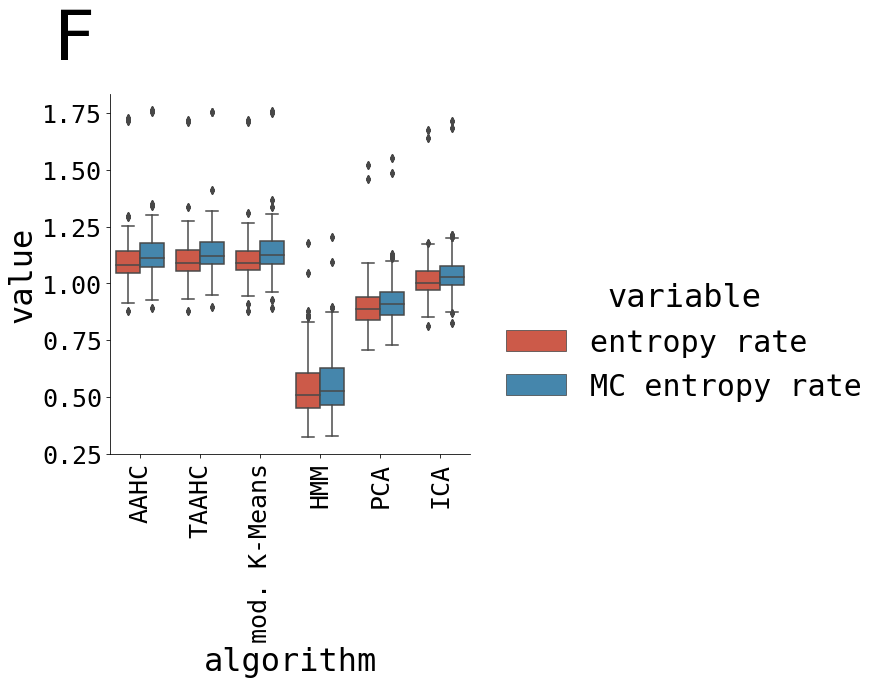

In [15]:
g = sns.catplot(
    data=stats.set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)
g.axes[0][0].text(
    -0.1,
    1.15,
    "F",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)

g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [16]:
subj_topo = (
    xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))
    .squeeze()
    .sel({"data_type": EOC, "surrogate_type": DATA_TYPE})
    .rename({"decomposition_type": "algorithm"})
)
rename_algs = {
    "AAHC": "AAHC",
    "TAAHC": "TAAHC",
    "ICA": "ICA",
    "PCA": "PCA",
    "hmm": "HMM",
    "kmeans": "mod. K-Means",
}
subj_topo["algorithm"] = [
    rename_algs[str(alg.values)] for alg in subj_topo["algorithm"]
]
# subj_topo = subj_topo.stack(all=("data_type", "surrogate_type", "subject_id"))

In [17]:
all_corrs = []
for alg1 in subj_topo["algorithm"]:
    for alg2 in subj_topo["algorithm"]:
        for map1 in subj_topo["latent map"]:
            for map2 in subj_topo["latent map"]:
                corrs = (
                    xr.corr(
                        subj_topo.sel({"algorithm": alg1, "latent map": map1}),
                        subj_topo.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs)).clip(min=-1.0, max=1.0, keep_attrs=True)

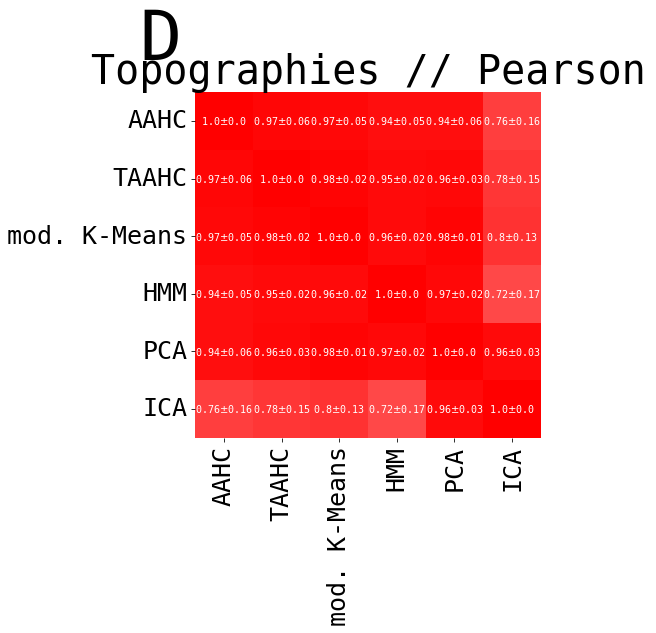

In [18]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject_id")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index.name = ""
mean.columns = mean.columns.get_level_values(1)
mean.columns.name = ""
mean = mean.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject_id", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std.index.name = ""
std.columns = std.columns.get_level_values(1)
std.columns.name = ""
std = std.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

g6 = pw.Brick("ax2", figsize=(6, 6))
sns.heatmap(
    mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=mean.round(2).astype(str) + "$\pm$" + std.round(2).astype(str),
    fmt="",
    ax=g6,
)
g6.text(
    -0.1,
    1.15,
    "D",
    ha="center",
    va="center",
    transform=g6.transAxes,
    fontsize=70,
)
g6.set_title("Topographies // Pearson")
g6.savefig(quick=True)

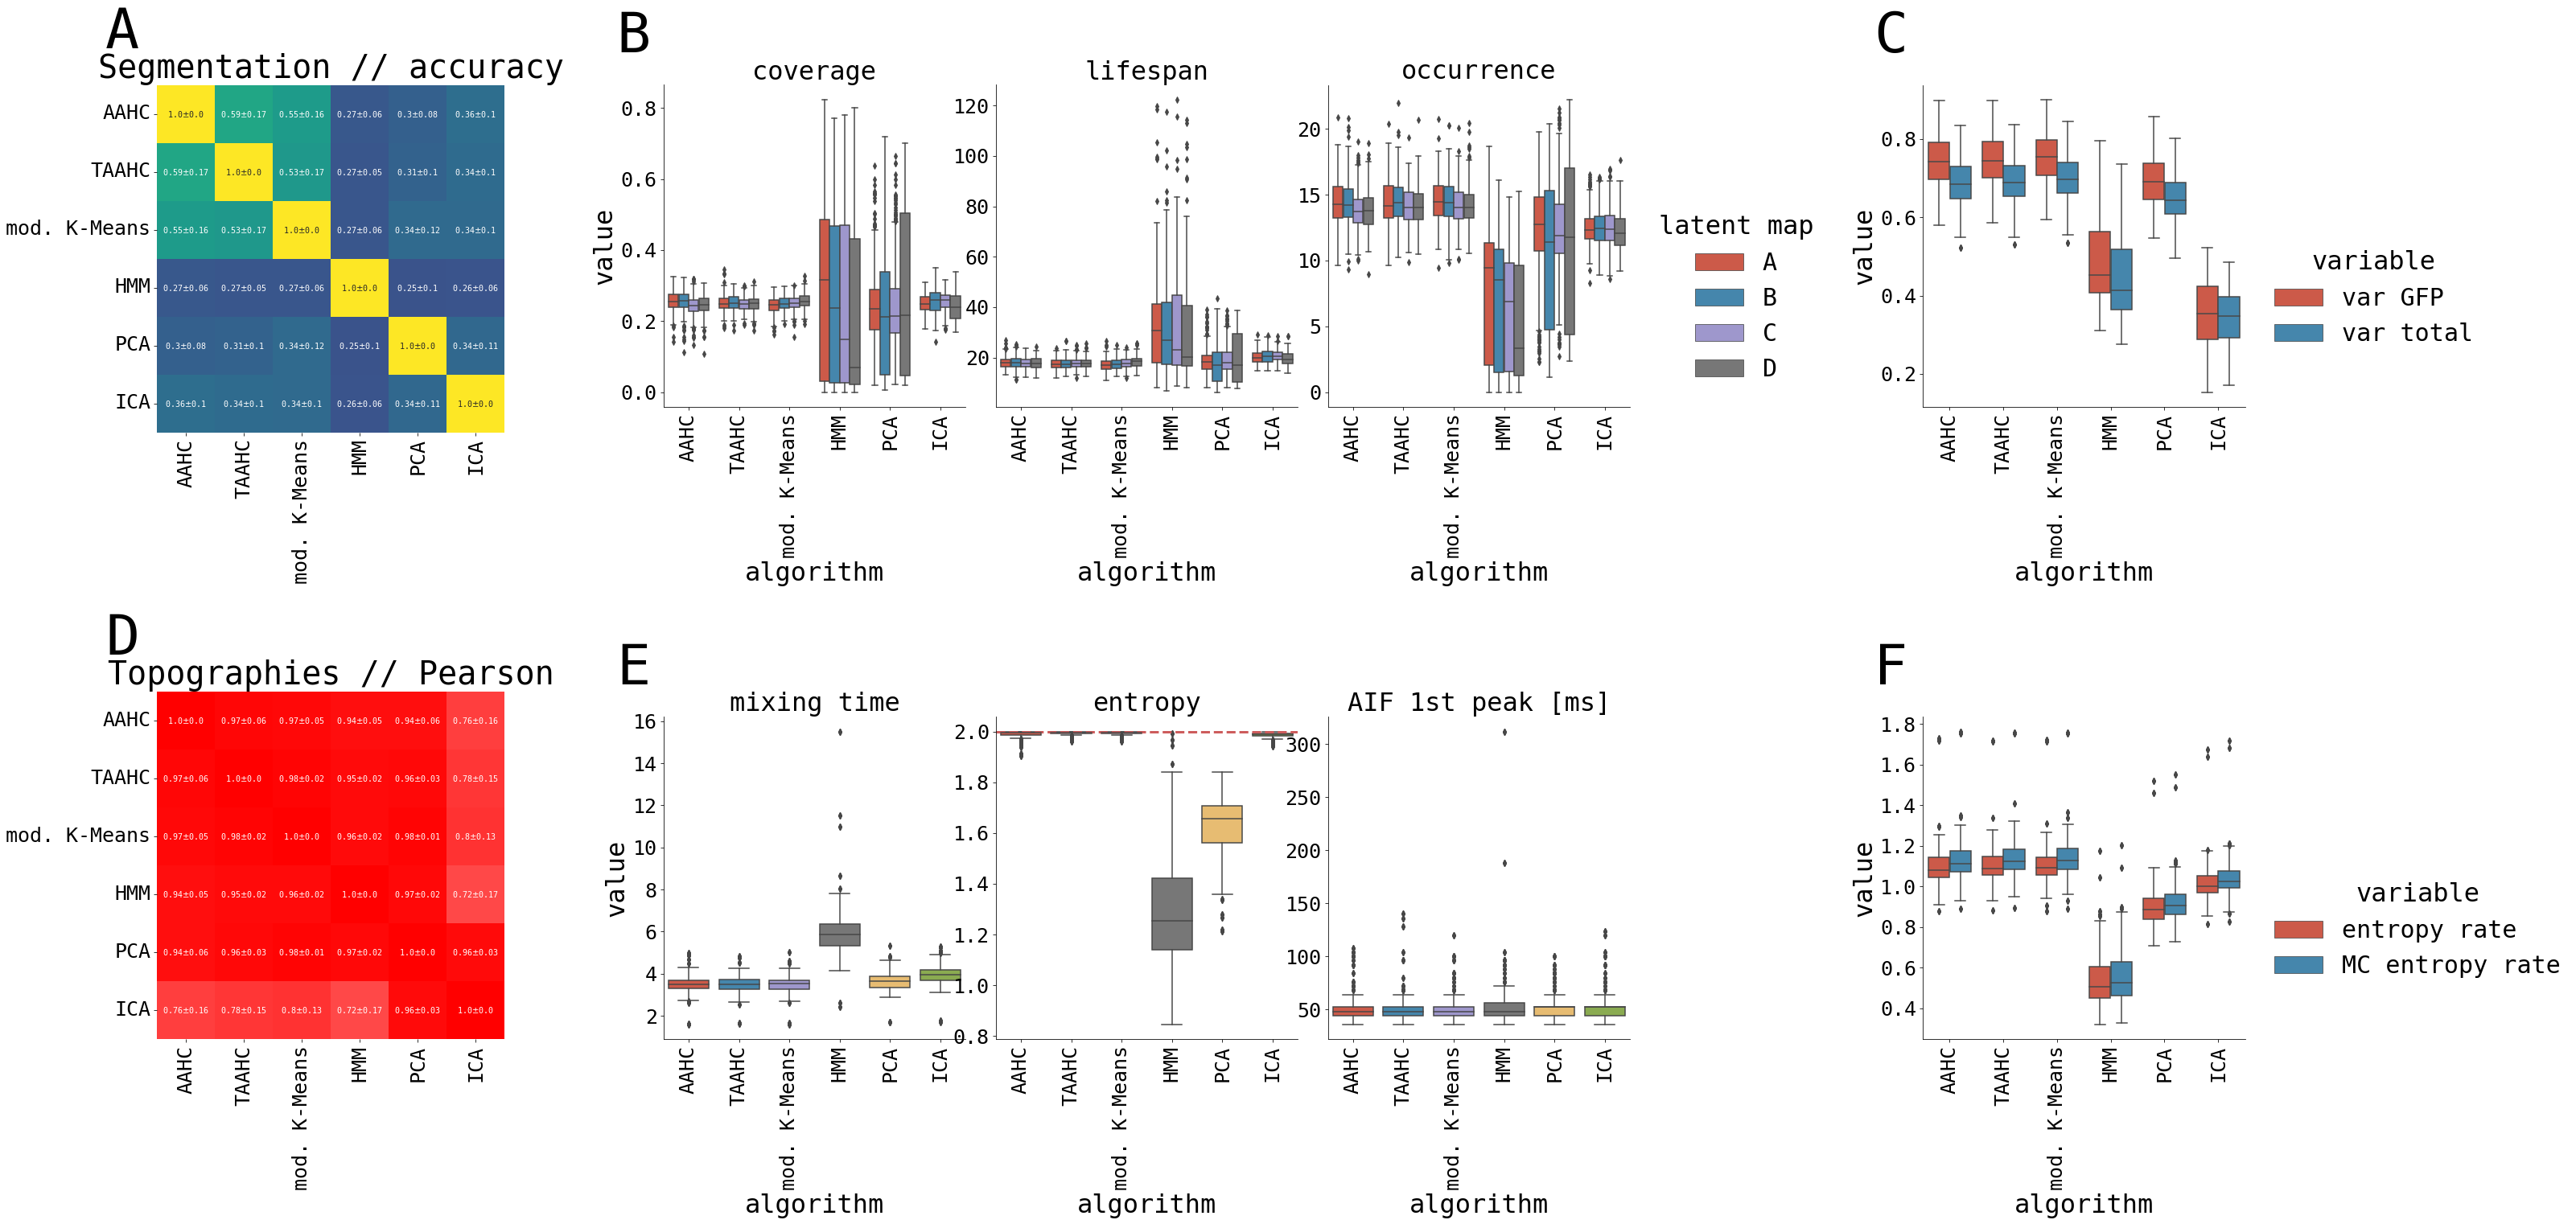

In [19]:
((g1 / g6) | (g2 / g4) | (g3 / g5)).savefig(
    fname=f"LEMON_{DATA_TYPE}_{EOC}_stats.pdf", transparent=True
)